In [1]:
# trees.r
# MWL, Lecture 2
# Author(s): [Phil Snyder]

In [2]:
#install.packages("mlbench", repos="http://cran.rstudio.com/") # we can download new libraries right from the R terminal!
library("mlbench")
#help(package="mlbench")
data(BreastCancer)
#help(topic="BreastCancer", package="mlbench")
BreastCancer$Id <- NULL # Just get rid of this column. We won't need it.

In [3]:
# Let's fit a tree to our data
library(rpart) # rpart stands for "recursive partitioning"
basicTree <- rpart(Class ~ ., BreastCancer, method='class')
basicTree

n= 699 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 699 241 benign (0.65522175 0.34477825)  
   2) Cell.size=1,2 429  12 benign (0.97202797 0.02797203)  
     4) Normal.nucleoli=1,2,3,8 421   5 benign (0.98812352 0.01187648) *
     5) Normal.nucleoli=4,6,7,10 8   1 malignant (0.12500000 0.87500000) *
   3) Cell.size=3,4,5,6,7,8,9,10 270  41 malignant (0.15185185 0.84814815)  
     6) Cell.shape=1,2 23   5 benign (0.78260870 0.21739130)  
      12) Bare.nuclei=1,3,5 16   0 benign (1.00000000 0.00000000) *
      13) Bare.nuclei=2,4,10 7   2 malignant (0.28571429 0.71428571) *
     7) Cell.shape=3,4,5,6,7,8,9,10 247  23 malignant (0.09311741 0.90688259)  
      14) Cell.size=1,2,3,4 70  18 malignant (0.25714286 0.74285714)  
        28) Bare.nuclei=1,2 14   4 benign (0.71428571 0.28571429) *
        29) Bare.nuclei=3,4,5,7,8,9,10 56   8 malignant (0.14285714 0.85714286) *
      15) Cell.size=5,6,7,8,9,10 177   5 malignant (0.02824859 0.97175141) *

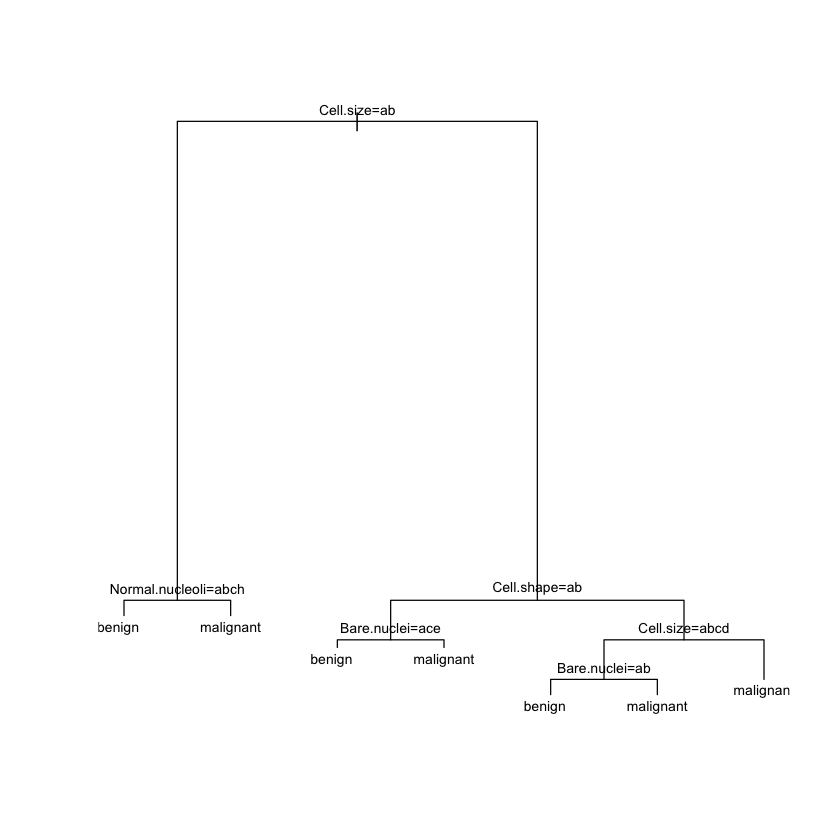

In [4]:
plot(basicTree) 
text(basicTree, cex=0.7) # cex controls text size

The split labels are generated by R, so they don't appear to make any sense. See the text description of the tree above for the actual split criteria.

In [21]:
basicTreePredictions <- predict(basicTree, BreastCancer, type='class')
basicTreeResults <- table(basicTreePredictions == BreastCancer$Class) / length(basicTreePredictions)
basicTreeResults


     FALSE       TRUE 
0.03576538 0.96423462 

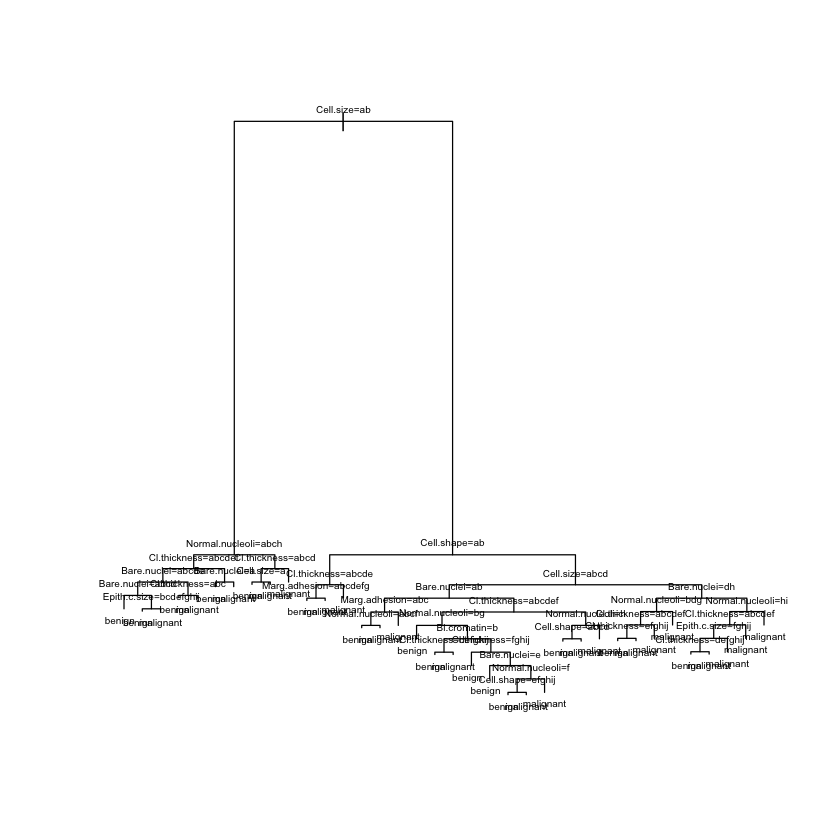

In [22]:
# Why don't we try growing our tree so far down that every node contains only one class?
godTree <- rpart(Class ~ ., BreastCancer, method='class', 
                 control=c(cp=-1, minsplit=2, minbucket=1))
plot(godTree)
text(godTree, cex=0.5) 

In [7]:
godTreePredictions <- predict(godTree, BreastCancer, type='class')
godTreeResults <- table(godTreePredictions == BreastCancer$Class) / length(godTreePredictions)
godTreeResults


TRUE 
   1 

Amazing! We have a perfect predictor. All other machine learning algorithms cower in 
sight of the glorious predictive power of godTree.

Of course, I'm kidding. What happens when a new data point comes along and, due to 
uncertainty, randomness, etc., doesn't conform perfectly to the model we have constructed?
We are interested in how well our predictor performs on *unseen*, future data, so we must 
'holdout' some data when we fit our model, then see how well the model performs on our
holdout data. This will give us a good estimate of how well our model *actually* performs
on unseen data.

In general, we partition our data into a 'train' set, which we fit our model to, 
and a 'test' set, which we evaluate our model on. This is the most basic form of 
cross-validation.

In [8]:
partition <- sample(nrow(BreastCancer), floor(0.7 * nrow(BreastCancer)))
trainData <- BreastCancer[partition,]
testData <- BreastCancer[-partition,] # can you guess what the '-' operator is doing here?

godTree <- rpart(Class ~ ., trainData, method='class', 
                 control=c(cp=-1, minsplit=2, minbucket=1))
godTreeTrainPredictions <- predict(godTree, trainData, type='class')
godTreeTestPredictions <- predict(godTree, testData, type='class')

godTreeTrainResults <- table(godTreeTrainPredictions 
                             == trainData$Class) / length(godTreeTrainPredictions)

In [9]:
godTreeTrainResults # Accuracy on train set


TRUE 
   1 

In [10]:
godTreeTestResults <- table(godTreeTestPredictions 
                               == testData$Class) / length(godTreeTestPredictions)
godTreeTestResults # Accuracy on test set


     FALSE       TRUE 
0.04761905 0.95238095 

When we have significantly higher accuracy on the training data as opposed to the 
test data, this is called 'overfitting'. We fit our model to the train data **too** well.

We now have a model, and a way to more accurately test the predictive power of our model by partitioning our data into a training set and a test set. The question remains, what parameters should our model have, and what values should they take on? In the case of linear regression, our parameters are the slope and intercept of the regression line. In the case of decision trees, our parameters should control how far down we grow our tree. There are a few ways to do this, but in the rpart function we may control the growth of our tree by varying the complexity parameter (cp), the minimum # of data points in a node needed to consider a split (minsplit), the minimum # of data points that are allowed to sit in a leaf (minbucket), or the maxdepth of the tree (maxdepth). You may look up what exactly a [complexity parameter](https://cran.r-project.org/web/packages/rpart/vignettes/longintro.pdf) is (Page 25), but all you really need to know is that the lower your cp, the more your tree will grow (subject to the minsplit, minbucket, maxdepth constraints). Setting cp = -1 (like in the godTree example) will tell rpart to keep splitting until it cannot split anymore (again, subject to the minsplit, minbucket, maxdepth constraints).

In general, finding optimal parameters is an optimization problem. Usually a numerical optimization problem (i.e., there is no closed form optimal solution). More on this in later lectures.

We will use an algorithm called 'grid search' to find an optimal parameter set. Grid search is just a fancy name for trying-every-reasonable-combination-of-parameters. Since cp, minsplit, minbucket, and maxdepth are each different ways of measuring the same thing, we can effectively tell rpart to ignore the minsplit, minbucket, and maxdepth constraints and only consider the cp.

In [18]:
# R is a functional language, so it can be frustratingly difficult to do something as 
# simple as add an element to the end of an array (vector). We use the foreach library
# to streamline the process. We will also be using a new dataset from a new library
# ElemStatLearn, 'Spam', which is more difficult to classify and illustrates 
# the concept better.

#install.packages(c("foreach", "ElemStatLearn"), repos="http://cran.rstudio.com/")
library("ElemStatLearn")
library("foreach")
data(spam)
#help(topic="spam", package="ElemStatLearn")
partition <- sample(nrow(spam), floor(0.7 * nrow(spam)))
trainData <- spam[partition,]
testData <- spam[-partition,] 

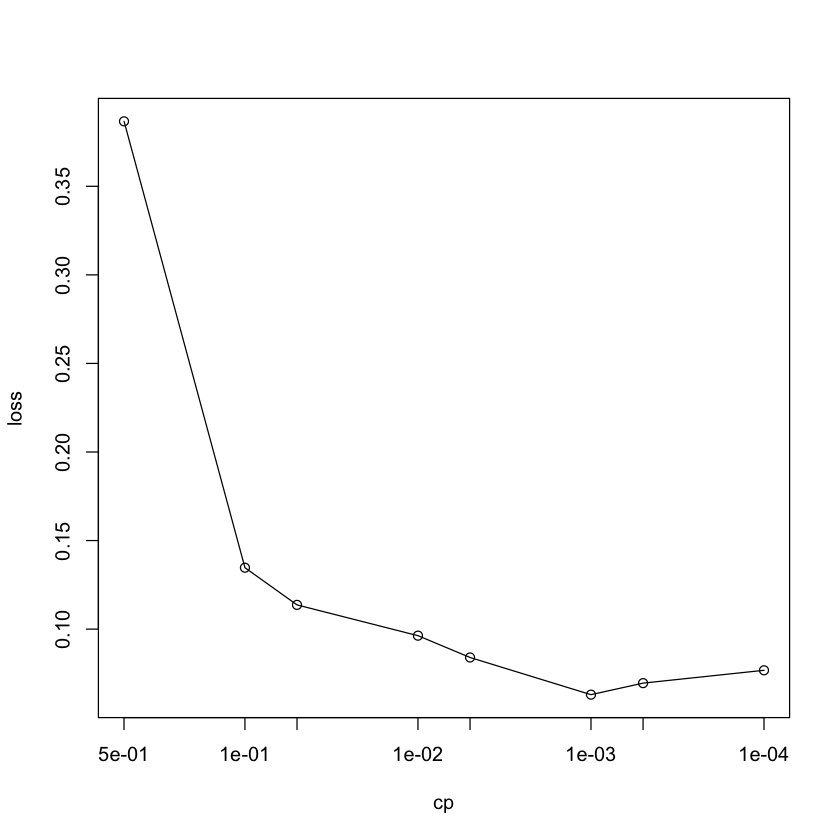

In [16]:
cpValues <- c(0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001)
treesLoss <- foreach(val = cpValues, .combine='c') %do% {
    ctrl <- rpart.control(cp=val, minsplit=2, minbucket=1) # maxdepth defaults to 30
    tree <- rpart(spam ~ ., trainData, method='class', control=ctrl)
    treePredictions <- predict(tree, testData, type='class')
    # proportion incorrect
    loss <- table(treePredictions == testData$spam)["FALSE"][[1]] / length(treePredictions)
    return(loss)
}
results <- data.frame(cp = cpValues, loss = treesLoss)
plot(results, log='x', xlim=c(max(results$cp), min(results$cp)), type='o') # x log scale and reversed

Great. Around 1e-3 seems optimal. BUT, we have made yet another naive mistake. Decision trees are *high variance* predictors. This means that the decision trees we generate are highly dependent on the specific data points in our training dataset. If we had sampled a different training set (and, as a consequence, a different test set, it's possible we may have had a different optimal value. To counterbalance this variability, we use k-fold cross-validation. Wikipedia has <a name="https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation">a nice paragraph on k-fold CV</a>.

In the link above, you can think of 'validation set' as a kind of test set. K-fold CV reduces variability (in the traditional statistical sense of the word) by averaging our results.

This issue alludes to something you will need to know about (eventually), but probably won't be covered this lecture. That is the [Bias-Variance Tradeoff]("https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff").

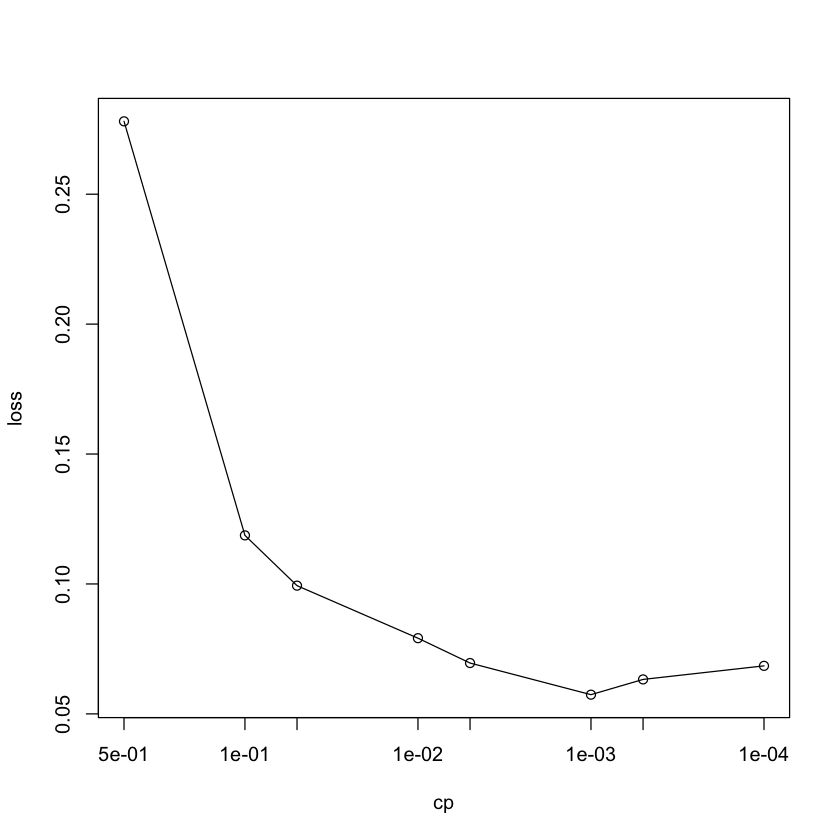

In [17]:
# do 10-fold CV
trainData <- trainData[sample(nrow(spam)),] # randomly permute the rows in our data frame
partitionSize <- floor(nrow(trainData) / 10)
treesLoss <- foreach(val = cpValues, .combine='c') %do% {
    ctrl <- rpart.control(cp=val, minsplit=2, minbucket=1) 
    summedResults <- 0
    for (i in seq(1, nrow(trainData) - partitionSize, partitionSize)) {
        validationSetIndices <- i:(i + partitionSize - 1) # seq from i to (partitionSize-1)
        validationData <- trainData[validationSetIndices,]
        nonValidationData <- trainData[-validationSetIndices,]
        tree <- rpart(spam ~ ., nonValidationData, method='class', control=ctrl)
        treePredictions <- predict(tree, validationData, type='class')
        loss <- table(treePredictions == validationData$spam)["FALSE"][[1]] / length(treePredictions)
        summedResults <- summedResults + loss
    }
    averagedResults <- summedResults / 10
    return(averagedResults)
}
cvResults <- data.frame(cp = cpValues, loss = treesLoss)
plot(cvResults, log='x', xlim=c(max(results$cp), min(results$cp)), type='o')

Now we have a nice, smooth(er) curve, and the optimal cp value will either be 1e-3 or 5e-4 depending on how easy to classify your test set happens to be (Sometimes we repeat the k-fold CV process itself multiple times to eliminate this 'lucky draw' element). If you're bored you can modify the code and plot the standard error bars on top of each data point. Another way of choosing the optimal parameter is to choose the value that gives the loosest fit to the training data yet is still within one standard error of the "best" value.

In [25]:
# So (approximately) how good is a decision tree with an optimal parameter value?
bestTree <- rpart(spam ~ ., trainData, method='class', 
                      control=c(cp=1e-3, minsplit=2, minbucket=1))
bestTreePredictions <- predict(bestTree, testData, type='class')
bestTreeResults <- table(bestTreePredictions == testData$spam) / length(bestTreePredictions)


     FALSE       TRUE 
0.08616944 0.91383056 

Now that we've made it this far, I can tell you a secret: decision trees are relatively crude predictors. Yet we are still able to correctly identify over 90% of emails as either spam or not spam using a singe decision tree and the 'bag-of-words' model (this is how the variables in our spam data were generated, see [ESL 9.2.5]). To create even more powerful tree-based predictors, we must learn about ensembles... (see treeEnsembles.r)